# Exponential Modeling of COVID-19 Confirmed Cases
This is not a good model for long or even medium-term predictions, it is able to fit initial outbreaks quite well. Logistic modeling is more sophisticated and accurate.

### Defining our parameters and loading the data
Here am looking at the confirmed and fatal cases for Italy through March 17.

In [8]:
ESTIMATE_DAYS = 3
data_key = 'IT'
date_limit = '2020-03-17'

In [9]:
import pandas as pd
import seaborn as sns
sns.set()

df = pd.read_csv(f'https://storage.googleapis.com/covid19-open-data/v2/{data_key}/main.csv').set_index('date')

In [10]:
def get_outbreak_mask(data: pd.DataFrame, threshold: int = 10):
    ''' Returns a mask for > N confirmed cases '''
    return data['total_confirmed'] > threshold

In [11]:
cols = ['total_confirmed', 'total_deceased']
# Get data only for the columns we care about
df = df[cols]
# Get data only for the selected dates
df = df[df.index <= date_limit]
# Get data only after the outbreak begun
df = df[get_outbreak_mask(df)]

### Plotting the data
Let's take a first look at the data. A visual inspection will typically give us a lot of information.

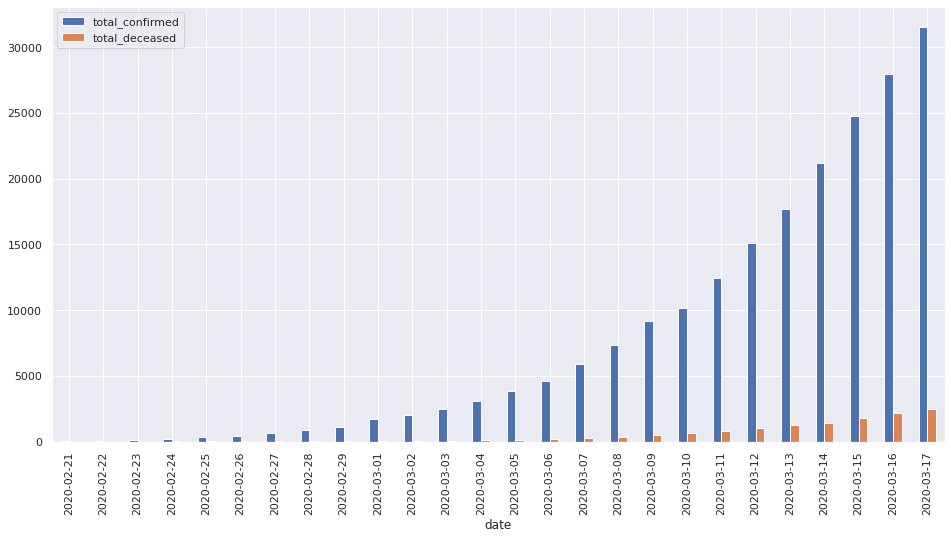

In [12]:
df.plot(kind='bar', figsize=(16, 8));

### Modeling the data
The data appears to follow an exponential curve.

In [13]:
from scipy import optimize

def exponential_function(x: float, a: float, b: float, c: float):
    ''' a * (b ^ x) + c '''
    return a * (b ** x) + c

X, y = list(range(len(df))), df['total_confirmed'].tolist()
params, _ = optimize.curve_fit(exponential_function, X, y)

print('Estimated function: {0:.3f} * ({1:.3f} ^ X) + {2:.3f}'.format(*params))

Estimated function: 787.500 * (1.162 ^ X) + -1273.966


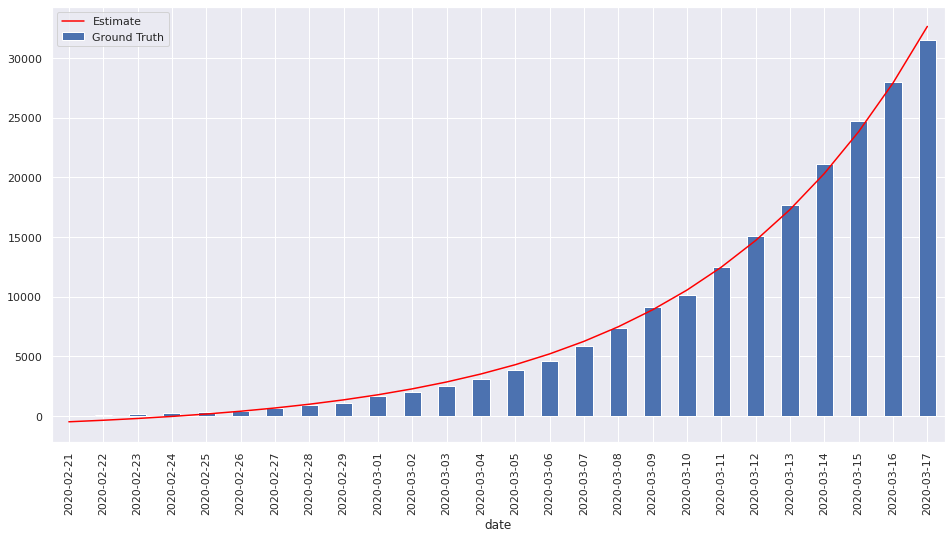

In [14]:
confirmed = df[['total_confirmed']].rename(columns={'total_confirmed': 'Ground Truth'})
ax = confirmed.plot(kind='bar', figsize=(16, 8))
estimate = [exponential_function(x, *params) for x in X]
ax.plot(df.index, estimate, color='red', label='Estimate')
ax.legend();

### Validating the model
That curve looks like a very good fit! Even though proper epidemiology models are fundamentally different (because diseases can't grow exponentially indefinitely), the exponential model should be good for short term predictions.


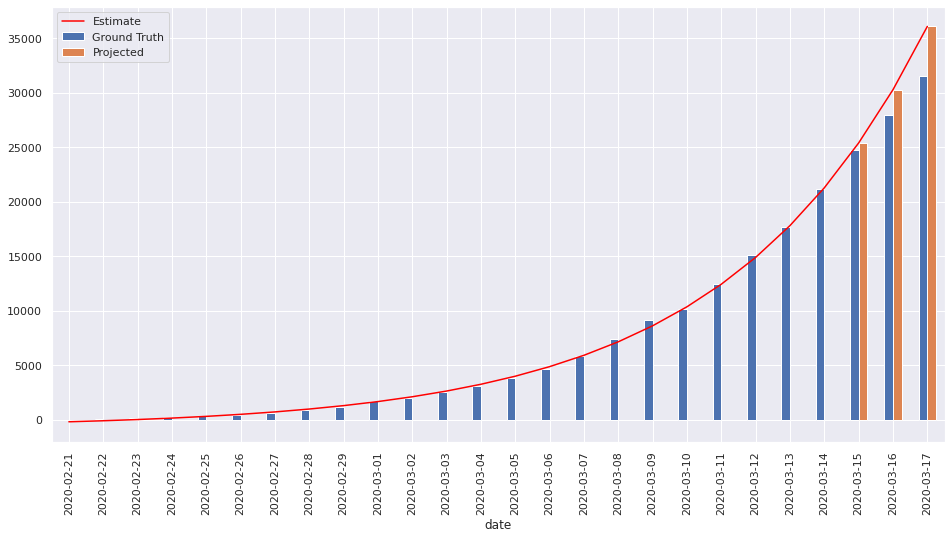

In [15]:
params_validate, _ = optimize.curve_fit(exponential_function, X[:-ESTIMATE_DAYS], y[:-ESTIMATE_DAYS])

# Project zero for all values except for the last ESTIMATE_DAYS
projected = [0] * len(X[:-ESTIMATE_DAYS]) + [exponential_function(x, *params_validate) for x in X[-ESTIMATE_DAYS:]]
projected = pd.Series(projected, index=df.index, name='Projected')
confirmed = pd.DataFrame({'Ground Truth': df['total_confirmed'], 'Projected': projected})
ax = confirmed.plot(kind='bar', figsize=(16, 8))
estimate = [exponential_function(x, *params_validate) for x in X]
ax.plot(df.index, estimate, color='red', label='Estimate')
ax.legend();

### Projecting future data
It looks like my exponential model slightly overestimates the confirmed cases. That's a good sign! It means that the disease is slowing down a bit. The numbers are close enough that a 3-day projection is probably an accurate enough estimate.

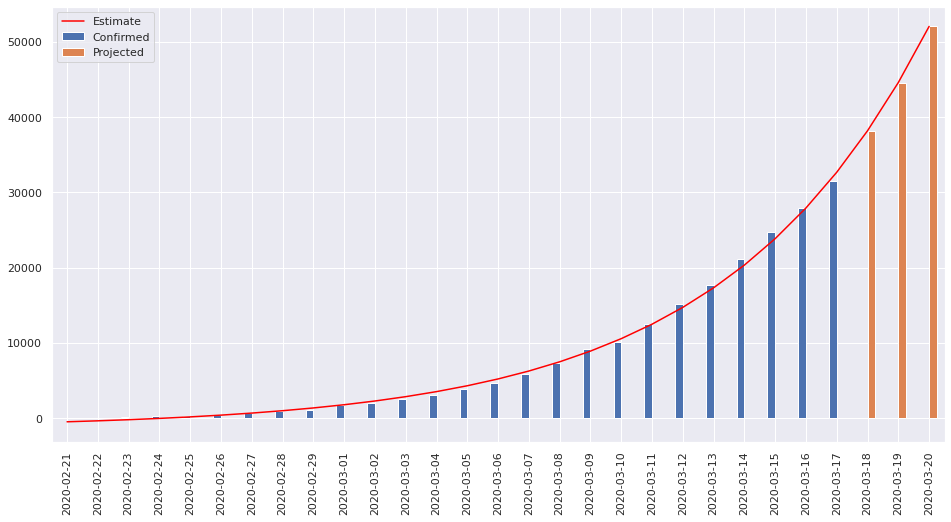

In [16]:
import datetime

# Append N new days to our indices
date_format = '%Y-%m-%d'
date_range = [datetime.datetime.strptime(date, date_format) for date in df.index]
for _ in range(ESTIMATE_DAYS): date_range.append(date_range[-1] + datetime.timedelta(days=1))
date_range = [datetime.datetime.strftime(date, date_format) for date in date_range]

# Perform projection with the previously estimated parameters
projected = [0] * len(X) + [exponential_function(x, *params) for x in range(len(X), len(X) + ESTIMATE_DAYS)]
projected = pd.Series(projected, index=date_range, name='Projected')
df_ = pd.DataFrame({'Confirmed': df['total_confirmed'], 'Projected': projected})
ax = df_.plot(kind='bar', figsize=(16, 8))
estimate = [exponential_function(x, *params) for x in range(len(date_range))]
ax.plot(date_range, estimate, color='red', label='Estimate')
ax.legend();